In [ ]:
import numpy as np
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt

CMAP = "cividis"

def getD1(S, K, sigma, dt, r):
    return (np.log(S / K) + (r + sigma**2 / 2) * dt) / \
        (sigma * np.sqrt(dt))

def getCallPrice(S, K, sigma, dt, r):
    if dt <= 0:
        return max([0, S - K])
    if K <= 0:
        return S
    d1 = getD1(S, K, sigma, dt, r)
    d2 = d1 - sigma * np.sqrt(dt)
    p = S * norm.cdf(d1) - K * \
        np.exp(-r * dt) * norm.cdf(d2)
    return p

spot = 2000
strike = 1000
vol = 1.
dt = 1.
r = 0.04
c = getCallPrice(spot, strike, vol, dt, r)
print(c)

1213.5222724814598


In [ ]:
def getFairApr(ltv, loanTenorInYears, spotPrice, vol, riskFreeRate):
    def minFunc(strike):
        y = spotPrice*ltv
        callPrice = getCallPrice(spotPrice, strike, vol, loanTenorInYears, riskFreeRate)
        z = spotPrice - callPrice - y
        z = z * 100 if z < 10 else z # scale up for small prices
        return z**2

    initStrikeGuess = spotPrice
    strikeBnds = (.0000001, None)
    initStrikeGuesses = np.linspace(strikeBnds[0], spotPrice*10, 10)
    for initStrikeGuess in initStrikeGuesses:
        res = optimize.minimize(
            minFunc,
            args=(),
            x0=[initStrikeGuess],
            bounds=[strikeBnds])
            
        if res["success"] and res["fun"] < 0.001:
            y = ltv*spotPrice
            strike = res['x'][0]
            apr = (strike/y-1)/loanTenorInYears
            return apr
    return None

ltv = .5
tenor = 90/365.
spot = 2000
vol = .8
r = .04

fairApr = getFairApr(ltv, tenor, spot, vol, r)
print(fairApr)

0.0798076372715767


In [ ]:
def getFairFee(ltv, loanTenorInYears, spotPrice, vol, riskFreeRate):
    def minFunc(fee):   
        y = spotPrice*ltv
        callPrice = getCallPrice(spotPrice, y/(1-fee), vol, loanTenorInYears, riskFreeRate)
        z = (1-fee)*(spotPrice - callPrice) - (y - fee*spotPrice)
        
        """
        # old calculation methodology
        callPrice = getCallPrice(spotPrice, y, vol, loanTenorInYears, riskFreeRate)
        z = spotPrice - (1-fee)*callPrice - y
        """
        
        z = z * 100 if z < 10 else z # scale up z for small prices
        return z**2
    
    maxFee = .999
    initFeeGuesses = np.linspace(0.0001, maxFee, 10)
    for initFeeGuess in initFeeGuesses:
        feeBnds = (.0, maxFee)
        res = optimize.minimize(
            minFunc,
            args=(),
            x0=[initFeeGuess],
            bounds=[feeBnds])
            
        if res["success"] and res["fun"] < 0.001:
            fee = res['x'][0]
            return fee
            
    return None

ltv = .5
tenor = 90/365.
spot = 2000
vol = .8
r = .04

fairUpfrontFee = getFairFee(ltv, tenor, spot, vol, r)
implYield = fairUpfrontFee/ltv/tenor
print(fairUpfrontFee)
print(implYield)

0.009384834796333646
0.07612143779248402


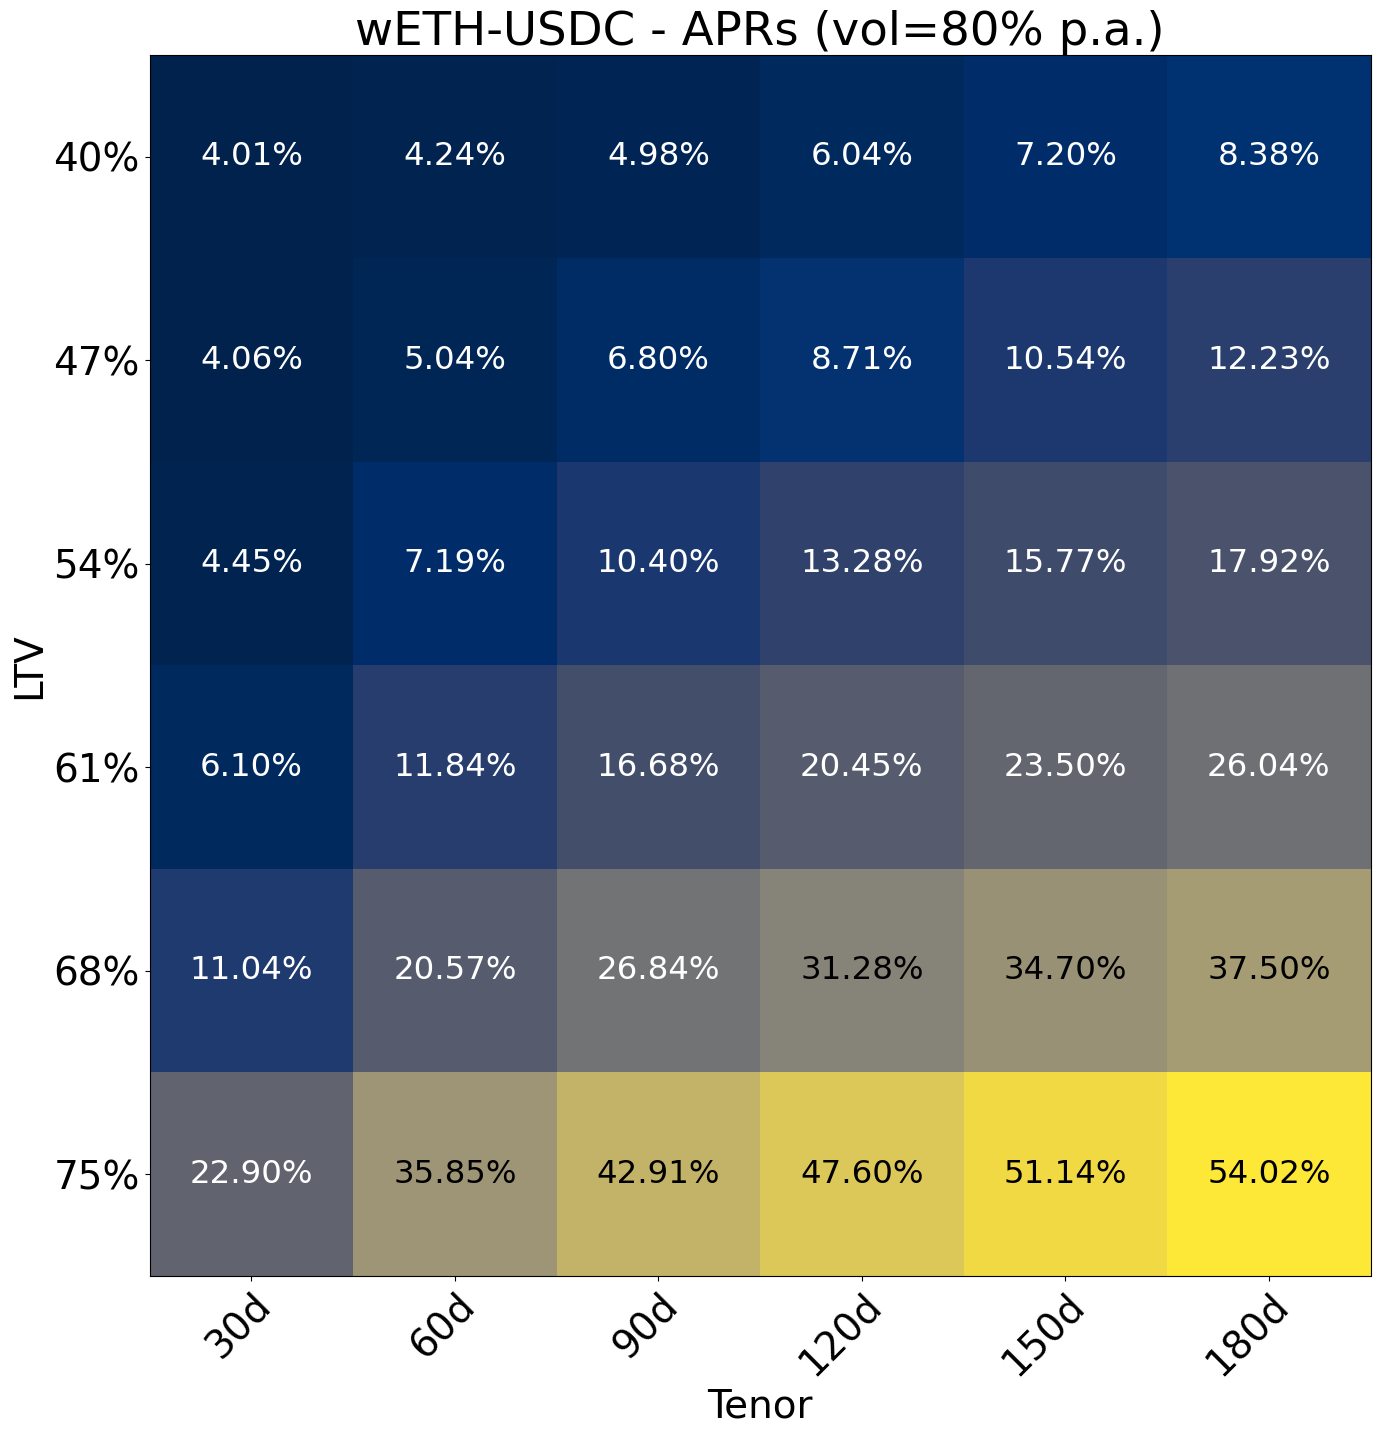

<Figure size 640x480 with 0 Axes>

In [ ]:

def upfrontFeeHeatmap(params):
    feeRes = []
    for ltv in params["ltvRange"]:
        tmp = []
        params["ltv"] = ltv
        for vol in params["volRange"]:
            args = dict((k, params[k]) for k in ("ltv", "loanTenorInYears", "spotPrice", "riskFreeRate"))
            args["vol"] = vol
            fee = getFairFee(**args)
            tmp.append(fee)
        feeRes.append(tmp)
    
    plt.rcParams.update({'font.size': 28})
    fig, ax = plt.subplots(figsize=(15, 15))
    cmap = plt.cm.get_cmap(CMAP)
    ax.imshow(feeRes, cmap=CMAP)
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(params["volRange"])), labels=["{:.0f}%".format(x*100) for x in params["volRange"]])
    ax.set_yticks(np.arange(len(params["ltvRange"])), labels=["{:.0f}%".format(x*100) for x in params["ltvRange"]])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    normColors = plt.cm.colors.Normalize(vmin=np.min(feeRes), vmax=np.max(feeRes))
    for i in range(len(params["ltvRange"])):
        for j in range(len(params["volRange"])):
            bg = cmap(normColors(feeRes[i][j]))
            v = 0 if (bg[0] + bg[1] + bg[2]) / 3 > 0.5 else 1
            c = (v, v, v, 1.)
            ax.text(j, i, "{:.2f}%".format(feeRes[i][j]*100),
                    ha="center", va="center", color=c, fontsize="smaller")
    
    ax.set_title("{} - Upfront Fees (tenor={:.1f}y)".format(params["pair"], params["loanTenorInYears"]))
    ax.set_ylabel("LTV")
    ax.set_xlabel("Vol.")
    fig.tight_layout()
    plt.show()
    fig.savefig('{} - fees.png'.format(params["pair"]), dpi=fig.dpi)
    plt.clf()
    
def aprHeatmap(params):
    aprRes = []
    for ltv in params["ltvRange"]:
        tmp = []
        params["ltv"] = ltv
        for vol in params["volRange"]:
            args = dict((k, params[k]) for k in ("ltv", "loanTenorInYears", "spotPrice", "riskFreeRate"))
            args["vol"] = vol
            apr = getFairApr(**args)
            tmp.append(apr)
        aprRes.append(tmp)
    
    plt.rcParams.update({'font.size': 28})
    fig, ax = plt.subplots(figsize=(15, 15))
    cmap = plt.cm.get_cmap(CMAP)
    ax.imshow(aprRes, cmap=CMAP)
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(params["volRange"])), labels=["{:.0f}%".format(x*100) for x in params["volRange"]])
    ax.set_yticks(np.arange(len(params["ltvRange"])), labels=["{:.0f}%".format(x*100) for x in params["ltvRange"]])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    normColors = plt.cm.colors.Normalize(vmin=np.min(aprRes), vmax=np.max(aprRes))
    for i in range(len(params["ltvRange"])):
        for j in range(len(params["volRange"])):
            bg = cmap(normColors(aprRes[i][j]))
            v = 0 if (bg[0] + bg[1] + bg[2]) / 3 > 0.5 else 1
            c = (v, v, v, 1.)
            ax.text(j, i, "{:.2f}%".format(aprRes[i][j]*100),
                    ha="center", va="center", color=c, fontsize="smaller")
    
    ax.set_title("{} - APRs (tenor={:.1f}y)".format(params["pair"], params["loanTenorInYears"]))
    ax.set_ylabel("LTV")
    ax.set_xlabel("Vol.")
    fig.tight_layout()
    plt.show()
    fig.savefig('{} - aprs.png'.format(params["pair"]), dpi=fig.dpi)
    plt.clf()

def aprHeatmap2(params):
    aprRes = []
    for ltv in params["ltvRange"]:
        tmp = []
        params["ltv"] = ltv
        for tenor in params["tenorRange"]:
            args = dict((k, params[k]) for k in ("ltv", "vol", "spotPrice", "riskFreeRate"))
            args["loanTenorInYears"] = tenor
            apr = getFairApr(**args)
            tmp.append(apr)
        aprRes.append(tmp)
    
    plt.rcParams.update({'font.size': 28})
    fig, ax = plt.subplots(figsize=(15, 15))
    cmap = plt.cm.get_cmap(CMAP)
    ax.imshow(aprRes, cmap=CMAP)
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(params["tenorRange"])), labels=["{:.0f}d".format(int(x*365/30)*30) for x in params["tenorRange"]])
    ax.set_yticks(np.arange(len(params["ltvRange"])), labels=["{:.0f}%".format(x*100) for x in params["ltvRange"]])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    normColors = plt.cm.colors.Normalize(vmin=np.min(aprRes), vmax=np.max(aprRes))
    for i in range(len(params["ltvRange"])):
        for j in range(len(params["tenorRange"])):
            bg = cmap(normColors(aprRes[i][j]))
            v = 0 if (bg[0] + bg[1] + bg[2]) / 3 > 0.5 else 1
            c = (v, v, v, 1.)
            ax.text(j, i, "{:.2f}%".format(aprRes[i][j]*100),
                    ha="center", va="center", color=c, fontsize="smaller")
    
    ax.set_title("{} - APRs (vol={:.0f}% p.a.)".format(params["pair"], params["vol"]*100))
    ax.set_ylabel("LTV")
    ax.set_xlabel("Tenor")
    fig.tight_layout()
    plt.show()
    fig.savefig('{} - aprs.png'.format(params["pair"]), dpi=fig.dpi)
    plt.clf()
    
params = {
    "pair": "wETH-USDC",
    "ltvRange": np.linspace(0.4, 0.75, num=6),
    "vol": .8,
    "spotPrice": 2000,
    "riskFreeRate": .04,
    "tenorRange": np.linspace(1/12, 6/12, num=6),
}
aprHeatmap2(params)

In [ ]:
def getK2(s, ltv, dt, vol1, vol2, coupon, r):
    def minFunc(k2):
        k1 = s*ltv*(1+coupon*dt)
        c1 = getCallPrice(s, k1, vol1, dt, r)
        c2 = getCallPrice(s, k2, vol2, dt, r)
        z = s - s*ltv - c1 + c2
        z = z * 100 if z < 10 else z # scale up for small prices
        return z**2
    
    initK2 = s
    strikeBnds = (.0000001, None)
    initStrikeGuesses = np.linspace(strikeBnds[0], initK2*10, 10)
    for initStrikeGuess in initStrikeGuesses:
        res = optimize.minimize(
            minFunc,
            args=(),
            x0=[initStrikeGuess],
            bounds=[strikeBnds])
            
        if res["success"] and res["fun"] < 0.001:
            k2 = res['x'][0]
            return k2
    return None

spot = .5
ltv = .5
dt = 1.
vol1 = 1.
vol2 = .5
coupon = .05
r = .04

K2 = getK2(spot, ltv, dt, vol1, vol2, coupon, r)
print(K2)

0.712096622714592


In [ ]:
def getCoupon(s, ltv, dt, vol1, vol2, k2, r):
    def minFunc(coupon):
        k1 = s*ltv*(1+coupon*dt)
        c1 = getCallPrice(s, k1, vol1, dt, r)
        c2 = getCallPrice(s, k2, vol2, dt, r)
        z = s - s*ltv - c1 + c2
        z = z * 100 if z < 10 else z # scale up for small prices
        return z**2
    
    couponBnds = (-.1, None)
    initCouponGuesses = np.linspace(couponBnds[0], 2, 10)
    for initCouponGuess in initCouponGuesses:
        res = optimize.minimize(
            minFunc,
            args=(),
            x0=[initCouponGuess],
            bounds=[couponBnds])
            
        if res["success"] and res["fun"] < 0.001:
            coupon = res['x'][0]
            return coupon
    return None

spot = .5
ltv = .5
dt = 1.
vol1 = 1.
vol2 = .5
k2 = 0.712096622714592
r = .04

coupon = getCoupon(spot, ltv, dt, vol1, vol2, k2, r)
print(coupon)

0.049999988374870914
